In [1]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, tqdm_notebook
import math

from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks
from scipy.integrate import simps
from scipy.io import loadmat

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:3168: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc')
octave.addpath(eeglab_path + 'popfunc')
octave.addpath(eeglab_path + 'adminfunc')
octave.addpath(eeglab_path + 'sigprocfunc')
octave.addpath(eeglab_path + 'miscfunc')

'.:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/sigprocfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/adminfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/popfunc:/home/raquib/Documents/MATLAB/eeglab2019_0/functions/guifunc:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/oct2py:/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/octave_kernel:/usr/lib/x86_64-linux-gnu/octave/4.2.2/site/oct/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/api-v51/x86_64-pc-linux-gnu:/usr/lib/x86_64-linux-gnu/octave/site/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/site/m:/usr/share/octave/site/api-v51/m:/usr/share/octave/site/m:/usr/share/octave/site/m/startup:/usr/lib/x86_64-linux-gnu/octave/4.2.2/oct/x86_64-pc-linux-gnu:/usr/share/octave/4.2.2/m:/usr/share/octave/4.2.2/m/audio:/usr/share/octave/4.2.2/m/debian:/usr/share/octave/4.2.2/m/deprecated:/usr/share/octave/4.2.2/m/elfun:/usr/share/octave/4.2.2/m/general:/usr/share/octave/4.2

In [3]:
eegs = ['data/original/sub03/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub03/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub03/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
         'data/original/sub03/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub03/exp02/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub03/exp03/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub03/exp03/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub03/exp03/eeg/SP 110RMT r3/05-clean-prestimulus.set',
         'data/original/sub04/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub04/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub04/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
        #  'data/original/sub05/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set', # NO MEP
        #  'data/original/sub05/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set', # NO MEP
         'data/original/sub05/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
         'data/original/sub06/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub06/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub06/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
         'data/original/sub06/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub07/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub07/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub07/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
         'data/original/sub08/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub08/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub08/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
         'data/original/sub08/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub08/exp03/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub08/exp03/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub08/exp03/eeg/SP 110RMT r3/05-clean-prestimulus.set',
         'data/original/sub09/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub10/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub10/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub10/exp02/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub10/exp02/eeg/SP 110RMT r3/05-clean-prestimulus.set',
         'data/original/sub11/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub11/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub12/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub12/exp02/eeg/SP 110RMT r1/05-clean-prestimulus.set',
        #  'data/original/sub13/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set', # LEFT HANDED
        #  'data/original/sub14/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set', # BAD MEP
         'data/original/sub15/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub15/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub15/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
         'data/original/sub16/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub16/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub16/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
        
         'data/original/sub18/exp01/eeg/SP 110RMT r1/05-clean-prestimulus.set',
         'data/original/sub18/exp01/eeg/SP 110RMT r2/05-clean-prestimulus.set',
         'data/original/sub18/exp01/eeg/SP 110RMT r3/05-clean-prestimulus.set',
]

rejected_trials = [
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 50},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 51},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 52},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 53},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 54},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 55},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 56},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 57},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 58},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 59},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': 60},
    {'sub': 'sub08', 'exp': 'exp03', 'run': 'r1', 'trial': 0},
    {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
    {'sub': 'sub11', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
    {'sub': 'sub11', 'exp': 'exp02', 'run': 'r1', 'trial': 38},
    {'sub': 'sub12', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
    {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
    {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 36},
    {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 44},
    
    
    {'sub': 'sub03', 'exp': 'exp02', 'run': 'r2', 'trial': '*'},
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r2', 'trial': 0},
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r3', 'trial': 22},
    {'sub': 'sub03', 'exp': 'exp01', 'run': 'r3', 'trial': 39},
    {'sub': 'sub03', 'exp': 'exp03', 'run': 'r3', 'trial': 21},
    {'sub': 'sub05', 'exp': 'exp01', 'run': 'r3', 'trial': '*'},
    {'sub': 'sub06', 'exp': 'exp01', 'run': 'r2', 'trial': 8},
    {'sub': 'sub06', 'exp': 'exp01', 'run': 'r2', 'trial': 22},
    {'sub': 'sub06', 'exp': 'exp01', 'run': 'r2', 'trial': 24},
    {'sub': 'sub06', 'exp': 'exp01', 'run': 'r2', 'trial': 37},
    {'sub': 'sub06', 'exp': 'exp02', 'run': 'r1', 'trial': 48},
    {'sub': 'sub06', 'exp': 'exp02', 'run': 'r1', 'trial': 49},
    {'sub': 'sub06', 'exp': 'exp02', 'run': 'r1', 'trial': 33},
    {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 38},
    {'sub': 'sub07', 'exp': 'exp01', 'run': 'r2', 'trial': 24},
    {'sub': 'sub08', 'exp': 'exp01', 'run': 'r1', 'trial': 40},
    {'sub': 'sub08', 'exp': 'exp01', 'run': 'r1', 'trial': 7},
    {'sub': 'sub08', 'exp': 'exp01', 'run': 'r3', 'trial': 47},
    {'sub': 'sub08', 'exp': 'exp02', 'run': 'r1', 'trial': 0},
    {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
    {'sub': 'sub09', 'exp': 'exp01', 'run': 'r1', 'trial': 1},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 26},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 18},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 17},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 16},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 15},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 14},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 13},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 12},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 11},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 10},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 9},
    {'sub': 'sub10', 'exp': 'exp01', 'run': 'r1', 'trial': 8},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': 15},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': 31},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': 37},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r1', 'trial': 41},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r2', 'trial': 37},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r2', 'trial': 42},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 23},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 24},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 25},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 26},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 27},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 28},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 29},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 30},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 31},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 32},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 33},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 34},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 35},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 36},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 37},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 38},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 39},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 40},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 41},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 42},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 43},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 44},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 45},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 46},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 47},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 48},
    {'sub': 'sub10', 'exp': 'exp02', 'run': 'r3', 'trial': 49},
    {'sub': 'sub12', 'exp': 'exp01', 'run': 'r1', 'trial': 0},
    {'sub': 'sub12', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
    {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 44},
    {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 36},
    {'sub': 'sub12', 'exp': 'exp02', 'run': 'r1', 'trial': 14},
    {'sub': 'sub16', 'exp': 'exp01', 'run': 'r1', 'trial': '*'},
    {'sub': 'sub18', 'exp': 'exp01', 'run': 'r2', 'trial': 26},
    {'sub': 'sub18', 'exp': 'exp01', 'run': 'r3', 'trial': 47},

]

# Basic I/O and conversions.

In [4]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, 1000, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def read_trials_from_mat(filename):
    x = loadmat(filename)
    mat_trials = x['dat'][0][0][3][0]
    trials = []
    time = np.linspace(-1000, 1000, len(mat_trials[0][0]))
    for mat_trial in mat_trials:
        trials.append(pd.DataFrame({'C3': mat_trial[0], 'C4': mat_trial[1], 'time': time}))
    return trials

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

def crop_mep_region(mep_frame, crop_start=0.211, crop_end=0.4):
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped

def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

def get_mep_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    return mep_path

def calculate_mep_size(mep_frame):
    mep_cropped = crop_mep_region(mep_frame)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size, min_row, max_row

# Read CMAP file.
def read_cmap(path):
    df = pd.read_excel(path, sheet_name='Raw data', header=None)
    columns = []
    ix = 0
    for r in df.index.values:
        if df[0][r] == 'Channel':
            ix = r
            break
    for c in df.columns.values:
        if (df[c][ix] == 2):
            columns.append(c)
    for r in df.index.values:
        if df[0][r] == 'Time (ms)':
            ix = r
            break
    df2 = df[columns].iloc[np.linspace(ix+1, df.shape[0]-2, df.shape[0]-ix-2)]
    df2['time'] = df[0].iloc[np.linspace(ix+1, df.shape[0]-2, df.shape[0]-ix-2)]
    return df2

# Identify CMAP peaks.
def find_cmap_peaks(df):
    df2 = df[(df['time'] > 105) * (df['time'] < 120)]
    time = df2['time']
    mean_clean = np.mean(df2.drop('time', axis=1), axis=1)
    return mean_clean.max(), mean_clean.min()

def get_cmap_path(eeg_path):
    segments = eeg_path.split('/')
    segments[4] = 'cmap'
    del segments[5]
    segments = segments[:-1]
    cmap_path = '/'.join(segments) + '/*.xlsx'
    cmap_paths = glob.glob(cmap_path)
    if (len(cmap_paths) == 0):
        print('No CMAP found for ' + cmap_path)
        return ''
    return cmap_paths[0]

def get_mep_category_absolute_binary(mep_size):
    if mep_size <= .5:
        return 0
    else:
        return 1
    
def calculate_mep_categories_binary(mep_sizes):
    p1 = np.percentile(mep_sizes, 50)
    cat = np.ones(len(mep_sizes)) * (mep_sizes >= p1)
    return cat

def calculate_mep_categories_cmap_binary(mep_sizes, cmap):
    sizes = []
    for mep_size in mep_sizes:
        sizes.append(mep_size / cmap)
    p1 = np.percentile(sizes, 50)
    cat = np.ones(len(mep_sizes)) * (sizes >= p1)
    return cat

# MEP latency and duration

In [5]:
def calculate_mep_latency_duration(mep_frame, plot=False, title=None):    
    
    # Calculate prestimulus mean amplitude and std.
    std_limit = 5
    peak_lookup_start_time = .215
    apb_name = get_apb_column_name(mep_frame)
    cropped = crop_mep_region(mep_frame, crop_start=0, crop_end=0.198)[apb_name]
    mean_amp = np.mean(cropped.values)
    std = np.std(cropped)
    
    # Find the index of the first point where amp > 5 SD of mean prestimulus
    df_peak = mep_frame[mep_frame['s'] > peak_lookup_start_time]
    peak_time = 0
    for idx, row in df_peak.iterrows():
        if (row[apb_name] > std_limit * std + mean_amp or row[apb_name] < mean_amp - std_limit * std):
            peak_time = row['s']
            break

    latency_absolute = mep_frame[mep_frame['s'] == peak_time]['s'].values[0]
    latency = (latency_absolute - 0.2)
    
    # Calculate the MEP duration.
    std_limit = 6
    sample_count = mep_frame[mep_frame['s'] < 0.03].shape[0]
    df_mean = crop_mep_region(mep_frame, crop_start=0.26, crop_end=0.3)[apb_name]
    mean_amp = np.mean(df_mean.values)
    std = np.std(df_mean.values)
    consecutive_baseline_count = 0
    return_to_baseline_time = 0
    cropped = crop_mep_region(mep_frame, crop_start=latency_absolute, crop_end=0.3)
    for idx, row in cropped.iterrows():
        if (row[apb_name] < mean_amp + std_limit * std) and (row[apb_name] > mean_amp - std_limit * std):
            if consecutive_baseline_count == 0:
                return_to_baseline_time = row['s']
            consecutive_baseline_count += 1
        else:
            consecutive_baseline_count = 0
        if consecutive_baseline_count > sample_count:
            break
    
    if plot == True:
        plt.figure(figsize=(20,5))
        plt.plot(mep_frame.iloc[0:2000]['s'], mep_frame.iloc[0:2000][apb_name])
        plt.axvspan(latency_absolute, return_to_baseline_time, color='r', alpha=0.15)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (mV)')
        if title != None:
            plt.title(title)
    return latency, return_to_baseline_time

# Power and phase calculations

In [6]:
def blackman_harris_filter(channel, time, cutoffs, fs):
    numtaps = 51
    b = signal.firwin(numtaps, cutoffs, window='blackmanharris', fs=fs)
    filtered = signal.lfilter(b, 1, channel)
    delay = 0.5 * (numtaps - 1) / fs
    df = pd.DataFrame({
        'time': time-delay,
        'channel': filtered
    })
    return df

def get_phase(channel, time, band, fs=4096, plot=False):
    df_filtered = blackman_harris_filter(channel, time, [0.00001, band[0]], fs)
    df_filtered = blackman_harris_filter(df_filtered['channel'].values, df_filtered['time'].values, [band[1], fs/2-1], fs)    
    hilb = signal.hilbert(df_filtered[(df_filtered['time'] > -750) * (df_filtered['time'] < -1)]['channel'])
    phase = np.angle(hilb, deg=True)
    df_phase = pd.DataFrame(phase, columns=['phase'])
    df_phase['time'] = df_filtered[(df_filtered['time'] > -750) * (df_filtered['time'] < -1)]['time'].values
    
    if plot == True:
        plt.figure()
        plt.plot(df_phase['time'], df_phase['phase'])
        plt.plot(df_phase.iloc[-1]['time'], df_phase.iloc[-1]['phase'], 'o')
        plt.show()
    # df_phase = df_phase[df_phase['time'] <= -20]
    return df_phase.iloc[-1]['phase'] + 180

def get_power(channel, time, band, crop_start_millis=-150, fs=500, plot=False):
    # Crop.
    channel = channel[(time > crop_start_millis) * (time < -1)].values
    time = time[(time > crop_start_millis) * (time < -1)].values

    # Resample.
    ts = time[1] - time[0]
    secs = len(channel) * ts
    secs = secs/1000
    resampled = signal.resample(channel, int(secs*fs))
    resampled_time = np.linspace(time[0], time[-1], len(resampled))
    
    # PSD.
    try:
        
        # Welch method
#         freq, power = signal.welch(resampled * 10, fs, nperseg=fs/2, nfft=2000)
#         freq_res = freq[1] - freq[0]
#         idx_band = np.logical_and(freq >= band[0], freq <= band[1])
# #         mean_power = simps(power[idx_band], dx=freq_res)
#         df_power = pd.DataFrame({'freq': freq, 'power': power})
#         df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
#         mean_power = np.mean(df_power_in_band['power'])
# #         power = np.log(power)
        
#         # FFT method
#         power = np.log(np.abs(np.fft.fft(resampled, n=500)))
#         freq = np.linspace(0, fs, len(power))
        
#         # Burgs method
        p = pburg(resampled, 26, sampling=fs, NFFT=4096)
        power = p.psd
        freq = np.linspace(0, fs, len(power))
        # power = power / (1/freq)
        df_power = pd.DataFrame({'freq': freq, 'power': power})
        df_power = df_power[df_power['freq'] < fs/2]
        df_power_in_band = df_power[(df_power['freq'] >= band[0]) * (df_power['freq'] <= band[1])]
        mean_power = np.mean(df_power_in_band['power'])
    except:
        return 0

    if plot == True:
        plt.figure()
        plt.plot(df_power['freq'], df_power['power'])
        plt.axvspan(band[0], band[1], color='r', alpha=0.2)
        plt.axhline(mean_power, color='r')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('dB Power')

    return mean_power

# Combine EEG and others

In [7]:
def calculate_power_phase(trial):    
    phase_power_dict = {}
    for channel in ['C3', 'C4']:        
        phase_power_dict[channel + '_mu_phase'] = get_phase(trial[channel], trial['time'], [8, 12])
        phase_power_dict[channel + '_beta_phase'] = get_phase(trial[channel], trial['time'], [13, 30])
        phase_power_dict[channel + '_gamma_phase'] = get_phase(trial[channel], trial['time'], [30, 80])
        phase_power_dict[channel + '_low_beta_phase'] = get_phase(trial[channel], trial['time'], [12, 20])
        phase_power_dict[channel + '_high_beta_phase'] = get_phase(trial[channel], trial['time'], [20, 30])
        phase_power_dict[channel + '_low_gamma_phase'] = get_phase(trial[channel], trial['time'], [30, 46])
        phase_power_dict[channel + '_high_gamma_phase'] = get_phase(trial[channel], trial['time'], [46, 70])
        
        phase_power_dict[channel + '_mu_power'] = get_power(trial[channel], trial['time'], [8, 12])
        phase_power_dict[channel + '_beta_power'] = get_power(trial[channel], trial['time'], [13, 30])
        phase_power_dict[channel + '_gamma_power'] = get_power(trial[channel], trial['time'], [30, 80])
        phase_power_dict[channel + '_low_beta_power'] = get_power(trial[channel], trial['time'], [12, 20])
        phase_power_dict[channel + '_high_beta_power'] = get_power(trial[channel], trial['time'], [20, 30])
        phase_power_dict[channel + '_low_gamma_power'] = get_power(trial[channel], trial['time'], [30, 46])
        phase_power_dict[channel + '_high_gamma_power'] = get_power(trial[channel], trial['time'], [46, 70])
    return phase_power_dict
        
def process_trials(eeg_path):
    sub = eeg_path.split('/')[2]
    exp = eeg_path.split('/')[3]
    run = eeg_path.split('/')[5]
    
    trials = read_trials_from_mat(os.path.dirname(eeg_path) + "/07-ft-hjorth.mat")

    # Calculate CMAP.
    cmap_max, cmap_min = find_cmap_peaks(read_cmap(get_cmap_path(eeg_path)))
    cmap = cmap_max - cmap_min

    # Calculate MEP categories.
    mep_list = open_mep_as_df(get_mep_path(eeg_path))
    mep_sizes = []
    for mep_df in mep_list:
        size, _, _ = calculate_mep_size(mep_df)
        mep_sizes.append(size)
    mep_cmap_list = calculate_mep_categories_cmap_binary(mep_sizes, cmap)
    mep_percentile_list = calculate_mep_categories_binary(mep_sizes)
    
    # Calculate powers and phases. And combine the results in a df list.
    power_phase_list = []
    for trial_num in range(len(trials)):
        trial = trials[trial_num]
    
        # Ignore rejected trials.
        break_loop = False
        for rejected in rejected_trials:
            if (sub == rejected['sub']) and (exp == rejected['exp']) and (rejected['run'] == run) and ((rejected['trial'] == trial_num) or (rejected['trial'] == '*')):
                break_loop = True
                break
        if break_loop == True:
            break
            
        # Calculate MEP latency and duration.
        latency, duration = calculate_mep_latency_duration(mep_list[trial_num])
        if duration == 0:
            print('Skipping ' + sub + '/' + exp + '/' + run + '/' + str(trial_num) + ': because duration is 0')
            continue
        
        # Calculate phase and power.
        print('Processing ' + sub + '/' + exp + '/' + run + '/' + str(trial_num))
        try:
            power = calculate_power_phase(trial)
        except ValueError as e:
            print('Skipping ' + sub + '/' + exp + '/' + run + '/' + str(trial_num) + ': ' + str(e))
            continue

        power_phase_dict = power
        power_phase_dict['sub'] = sub
        power_phase_dict['exp'] = exp
        power_phase_dict['run'] = run
        power_phase_dict['trial_num'] = trial_num
        power_phase_dict['cmap'] = cmap
        power_phase_dict['mep_size'] = mep_sizes[trial_num]
        power_phase_dict['mep_cat_abs'] = get_mep_category_absolute_binary(mep_sizes[trial_num])
        power_phase_dict['mep_cat_percentile'] = mep_percentile_list[trial_num]
        power_phase_dict['mep_cat_cmap'] = mep_cmap_list[trial_num]
        power_phase_dict['mep_by_cmap'] = mep_sizes[trial_num] / cmap
        power_phase_dict['mep_latency'] = latency
        power_phase_dict['mep_duration'] = duration        
        power_phase_list.append(power_phase_dict)
    return power_phase_list

In [8]:
num_cores = multiprocessing.cpu_count()-2
results = Parallel(n_jobs=num_cores)(delayed(process_trials)(eeg_path) for eeg_path in tqdm_notebook(eegs))

In [9]:
df_powers = []
for result in results:
    if len(result) == 0:
        continue
    for trial in result:
        df_powers.append(trial)
len(df_powers)

df_power = pd.DataFrame(df_powers)
print(df_power.shape)
df_power.to_excel('133-hjorth-clean-v1.xlsx')

(2201, 40)


In [10]:
# MEP Normalization.
df_power['subexp'] = df_power['sub'] + '.' + df_power['exp']
df_new_powers = []
for subexp in tqdm(df_power['subexp'].unique()):
    df_sub = df_power[df_power['subexp'] == subexp]
    mep_size = df_sub['mep_size'].values
    mep_size = (mep_size - np.mean(mep_size)) / (np.max(mep_size) - np.min(mep_size))
    df_sub['mep_size'] = mep_size
    df_sub['mep_size_log'] = np.log(0.03+mep_size)
    df_sub['mep_by_cmap'] = mep_size / np.mean(df_sub['cmap'].values)
    df_sub['mep_by_cmap_log'] = np.log(0.002+df_sub['mep_by_cmap'].values)
    df_new_powers.append(df_sub)

  0%|          | 0/21 [00:00<?, ?it/s]/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/raquib/anaconda3/envs/tmseeg/lib/python3

In [11]:
new_powers = []
for block in df_new_powers:
    for idx, row in block.iterrows():
        new_powers.append(row)
df_new_powers = pd.DataFrame(new_powers)
df_new_powers.shape
df_new_powers.to_excel('133-mep-norm-clean-v1.xlsx')

# Remove outliers based on STD

Text(9.118000000000006, 0.5, 'Power')

<Figure size 720x288 with 0 Axes>

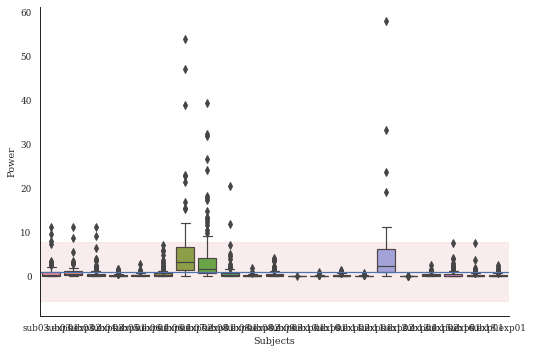

In [12]:
plt.figure(figsize=(10,4))

plt.tight_layout()
sns.set(font='serif')
sns.set_style("white", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"]
})
sns.set_context("paper")


plot_y = 'C3_mu_power'

sns.catplot(x="subexp", y=plot_y, kind="box", data=df_power, height=5, aspect=1.5)

mean = np.mean(df_power[plot_y].values)
std = np.std(df_power[plot_y].values)
plt.axhline(mean)
plt.axhspan(mean-2*std, mean+2*std, color='r', alpha=0.1)

plt.xlabel('Subjects')
plt.ylabel('Power')

In [13]:
channel = 'C3'

mu_power_mean = np.mean(df_power[channel + '_mu_power'])
mu_power_std = np.std(df_power[channel + '_mu_power'])
beta_power_mean = np.mean(df_power[channel + '_beta_power'])
beta_power_std = np.std(df_power[channel + '_beta_power'])
gamma_power_mean = np.mean(df_power[channel + '_gamma_power'])
gamma_power_std = np.std(df_power[channel + '_gamma_power'])

def is_outlier(row):
    if row[channel + '_mu_power'] > mu_power_mean + 2 * mu_power_std or row[channel + '_mu_power'] < mu_power_mean - 2 * mu_power_std or row[channel + '_beta_power'] > beta_power_mean + 2 * beta_power_std or row[channel + '_beta_power'] < beta_power_mean - 2 * beta_power_std or row[channel + '_gamma_power'] > gamma_power_mean + 2 * gamma_power_std or row[channel + '_gamma_power'] < gamma_power_mean - 2 * gamma_power_std:
        return True
    return False

df_powers2 = []
for idx, row in tqdm_notebook(df_power.iterrows(), total=df_power.shape[0]):
    if is_outlier(row) == False:
        df_powers2.append(row)
df_powers2 = pd.DataFrame(df_powers2)
df_powers2.shape
df_powers2.to_excel('133-ft-hjorth-no-outlier-v1.xlsx')

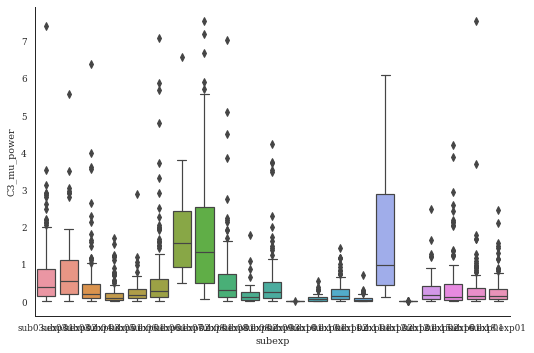

In [14]:
sns.catplot(x="subexp", y=plot_y, kind="box", data=df_powers2, height=5, aspect=1.5)